<a href="https://colab.research.google.com/github/ale-nunes/analise-de-imagens/blob/main/Projeto_Classifica%C3%A7%C3%A3o_de_C%C3%A3es_vs_Gatos_com_Transfer_Learning_e_Data_Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classificação Usando Transfer Learning e Data Augumentation

Este projeto usará Transfer Learning (Aprendizado por Transferência), uma das técnicas mais comuns em Visão Computacional. Em vez de construir e treinar uma rede do zero, vamos pegar uma rede neural de ponta, já treinada pela Google em milhões de imagens, e adaptá-la para o nosso problema específico.

**Objetivo:** Construir um classificador de alta precisão que diferencie imagens de cães e gatos.

**Por que este projeto é mais complexo e completo?**

* Dataset Real: Usaremos um dataset do Kaggle, o que exige um passo a mais de configuração para baixar e organizar os dados.
* Transfer Learning: Usaremos a arquitetura MobileNetV2, pré-treinada no gigantesco dataset ImageNet. Isso nos dará um ponto de partida muito mais forte.
Data Augmentation: Geraremos novas imagens de treino em tempo real (com rotações, zooms, etc.) para tornar nosso modelo mais robusto e evitar overfitting.
* Fine-Tuning: Faremos um processo de treinamento em duas fases: primeiro treinamos apenas o nosso classificador e depois "descongelamos" algumas camadas da rede pré-treinada para um ajuste fino, alcançando uma precisão ainda maior.
* Callbacks: Usaremos ModelCheckpoint para salvar automaticamente o melhor modelo e EarlyStopping para parar o treinamento se ele não estiver mais melhorando.
* Análise Detalhada: Além da acurácia, vamos gerar uma matriz de confusão para entender que tipo de erros o modelo comete.
Previsão em Imagem Real: Vamos criar uma função para testar o modelo com uma imagem qualquer da internet.

In [ ]:
# Célula para fazer o upload do seu token da API do Kaggle (se ainda não fez)
from google.colab import files
import os

# Apenas execute se o kaggle.json não existir
if not os.path.exists("/root/.kaggle/kaggle.json"):
    print("Por favor, faça o upload do seu arquivo kaggle.json")
    files.upload()
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json
else:
    print("Arquivo kaggle.json já configurado.")

Saving kaggle.json to kaggle.json


In [ ]:
# 1. Baixar o dataset do Kaggle
# A flag -p especifica o caminho para salvar e evita bagunça
!kaggle competitions download -c dogs-vs-cats

# 2. Verificar se o download funcionou
print("\nArquivos baixados:")
!ls /content/

# 3. Descompactar o arquivo principal 'dogs-vs-cats.zip'
# Ele contém os outros zips. O '-d .' especifica o diretório atual.
print("\nDescompactando o arquivo principal...")
!unzip -q /content/dogs-vs-cats.zip -d .

# 4. Verificar os arquivos descompactados (agora devemos ver train.zip e test1.zip)
print("\nArquivos após a primeira descompactação:")
!ls

# 5. Descompactar os arquivos de treino e teste
print("\nDescompactando train.zip e test1.zip...")
!unzip -q train.zip -d .
!unzip -q test1.zip -d .

# 6. VERIFICAÇÃO FINAL: Agora a pasta 'train' deve existir!
print("\nVerificando se a pasta 'train' foi criada:")
!ls

 97% 785M/812M [00:07<00:00, 157MB/s]
100% 812M/812M [00:07<00:00, 116MB/s]

Arquivos baixados:
cats_vs_dogs  dogs-vs-cats.zip	kaggle.json  sample_data

Descompactando o arquivo principal...

Arquivos após a primeira descompactação:
cats_vs_dogs	  kaggle.json  sampleSubmission.csv  train.zip
dogs-vs-cats.zip  sample_data  test1.zip

Descompactando train.zip e test1.zip...

Verificando se a pasta 'train' foi criada:
cats_vs_dogs	  kaggle.json  sampleSubmission.csv  test1.zip	train.zip
dogs-vs-cats.zip  sample_data  test1		     train


In [ ]:
import shutil
from sklearn.model_selection import train_test_split

base_dir = 'cats_vs_dogs'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

if os.path.exists(base_dir):
    shutil.rmtree(base_dir)

os.makedirs(train_cats_dir)
os.makedirs(train_dogs_dir)
os.makedirs(validation_cats_dir)
os.makedirs(validation_dogs_dir)

# Lista de todos os arquivos de treino
all_filenames = os.listdir('train')
# Usando um subconjunto para treinar mais rápido
filenames_subset, _ = train_test_split(all_filenames, train_size=5000, random_state=42, stratify=[fn.startswith('cat') for fn in all_filenames])
train_files, val_files = train_test_split(filenames_subset, test_size=0.2, random_state=42, stratify=[fn.startswith('cat') for fn in filenames_subset])

def copy_files(file_list, source_folder):
    for filename in file_list:
        src = os.path.join(source_folder, filename)
        if 'cat' in filename:
            dst = os.path.join(validation_cats_dir if source_folder == 'validation' else train_cats_dir, filename)
        else:
            dst = os.path.join(validation_dogs_dir if source_folder == 'validation' else train_dogs_dir, filename)
        shutil.copyfile(src, dst)

for filename in train_files:
    src = os.path.join('train', filename)
    if 'cat' in filename: dst = os.path.join(train_cats_dir, filename)
    else: dst = os.path.join(train_dogs_dir, filename)
    shutil.copyfile(src, dst)

for filename in val_files:
    src = os.path.join('train', filename)
    if 'cat' in filename: dst = os.path.join(validation_cats_dir, filename)
    else: dst = os.path.join(validation_dogs_dir, filename)
    shutil.copyfile(src, dst)

print('\nTotal de imagens de treino (gatos):', len(os.listdir(train_cats_dir)))
print('Total de imagens de treino (cães):', len(os.listdir(train_dogs_dir)))
print('Total de imagens de validação (gatos):', len(os.listdir(validation_cats_dir)))
print('Total de imagens de validação (cães):', len(os.listdir(validation_dogs_dir)))


Total de imagens de treino (gatos): 2000
Total de imagens de treino (cães): 2000
Total de imagens de validação (gatos): 500
Total de imagens de validação (cães): 500


Passo 1: Importar Bibliotecas e Definir Parâmetros

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt
import numpy as np

# Parâmetros
IMG_SIZE = (224, 224) # MobileNetV2 espera imagens de 224x224
BATCH_SIZE = 32

Passo 2: Criar Geradores de Dados com Data Augmentation

* ImageDataGenerator é uma ferramenta fantástica. Ele carrega as imagens do disco em lotes (para não sobrecarregar a memória) e aplica as transformações de augmentation em tempo real.

In [ ]:
# Criar o gerador para os dados de treino com Data Augmentation
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input # Normalização específica da MobileNetV2
)

# O gerador de validação não deve ter augmentation, apenas a normalização
validation_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

# Criar os geradores que leem as imagens dos diretórios
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary' # Porque temos 2 classes (cão/gato)
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

Found 4000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


Passo 3: Construir o Modelo com Transfer Learning

* Carregamos a MobileNetV2 sem a sua camada de classificação (include_top=False).
* "Congelamos" os pesos da MobileNetV2 para que eles não sejam atualizados no treinamento inicial.
* Adicionamos nosso próprio classificador no topo.

In [ ]:
# Carregar o modelo base (MobileNetV2) pré-treinado no ImageNet
base_model = MobileNetV2(input_shape=IMG_SIZE + (3,),
                         include_top=False, # Não incluir a camada de classificação final
                         weights='imagenet')

# Congelar o modelo base
base_model.trainable = False

# Construir nosso classificador no topo do modelo base
x = base_model.output
x = GlobalAveragePooling2D()(x) # Converte features em um único vetor por imagem
x = Dropout(0.5)(x) # Camada de Dropout para regularização (evitar overfitting)
x = Dense(128, activation='relu')(x)
# Camada de saída final com 1 neurônio e ativação sigmóide (para classificação binária)
outputs = Dense(1, activation='sigmoid')(x)

# Criar o modelo final
model = Model(inputs=base_model.input, outputs=outputs)

# Compilar o modelo
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Ver a arquitetura do modelo
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Passo 4: Treinamento - Fase 1 (Apenas o Classificador)

* Vamos treinar o modelo com a base congelada. Também definiremos callbacks para salvar o melhor modelo e parar o treinamento se necessário.

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Callbacks
checkpoint = ModelCheckpoint("best_model.h5", save_best_only=True, monitor="val_accuracy", mode="max")
early_stopping = EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True)

# Treinamento
initial_epochs = 10

history = model.fit(
    train_generator,
    epochs=initial_epochs,
    validation_data=validation_generator,
    callbacks=[checkpoint, early_stopping]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step - accuracy: 0.9083 - loss: 0.2104

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


125/125 ━━━━━━━━━━━━━━━━━━━━ 73s 486ms/step - accuracy: 0.9086 - loss: 0.2099 - val_accuracy: 0.9700 - val_loss: 0.0753
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - accuracy: 0.9571 - loss: 0.1094

125/125 ━━━━━━━━━━━━━━━━━━━━ 71s 462ms/step - accuracy: 0.9571 - loss: 0.1094 - val_accuracy: 0.9790 - val_loss: 0.0483
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 64s 512ms/step - accuracy: 0.9606 - loss: 0.1003 - val_accuracy: 0.9760 - val_loss: 0.0542
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step - accuracy: 0.9573 - loss: 0.1107

125/125 ━━━━━━━━━━━━━━━━━━━━ 66s 529ms/step - accuracy: 0.9573 - loss: 0.1106 - val_accuracy: 0.9800 - val_loss: 0.0438
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step - accuracy: 0.9615 - loss: 0.0915

125/125 ━━━━━━━━━━━━━━━━━━━━ 63s 501ms/step - accuracy: 0.9615 - loss: 0.0915 - val_accuracy: 0.9810 - val_loss: 0.0436
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 62s 494ms/step - accuracy: 0.9779 - loss: 0.0626 - val_accuracy: 0.9770 - val_loss: 0.0531
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step - accuracy: 0.9749 - loss: 0.0647

125/125 ━━━━━━━━━━━━━━━━━━━━ 63s 505ms/step - accuracy: 0.9749 - loss: 0.0647 - val_accuracy: 0.9820 - val_loss: 0.0421
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 60s 482ms/step - accuracy: 0.9716 - loss: 0.0716 - val_accuracy: 0.9820 - val_loss: 0.0387
Epoch 9/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step - accuracy: 0.9713 - loss: 0.0658

125/125 ━━━━━━━━━━━━━━━━━━━━ 61s 490ms/step - accuracy: 0.9713 - loss: 0.0658 - val_accuracy: 0.9830 - val_loss: 0.0422
Epoch 10/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step - accuracy: 0.9707 - loss: 0.0759

125/125 ━━━━━━━━━━━━━━━━━━━━ 55s 437ms/step - accuracy: 0.9707 - loss: 0.0759 - val_accuracy: 0.9850 - val_loss: 0.0338


Passo 5: Fine-Tuning - Fase 2 (Ajuste Fino)

* Agora, vamos "descongelar" as camadas superiores da MobileNetV2 e continuar o treinamento com uma taxa de aprendizado (learning_rate) muito baixa.
* Isso permite que o modelo ajuste os pesos pré-treinados especificamente para nosso dataset de cães e gatos.

In [ ]:
# Descongelar o modelo base
base_model.trainable = True

# Vamos descongelar a partir da camada 100 (um bom ponto de partida)
fine_tune_at = 100

# Congelar todas as camadas antes da camada `fine_tune_at`
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Recompilar o modelo com uma taxa de aprendizado muito baixa
model.compile(optimizer=Adam(learning_rate=1e-5), # 0.00001
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Continuar o treinamento (fine-tuning)
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(
    train_generator,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1] + 1, # Continuar de onde paramos
    validation_data=validation_generator,
    callbacks=[checkpoint, early_stopping]
)

Epoch 11/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 90s 514ms/step - accuracy: 0.8569 - loss: 0.3968 - val_accuracy: 0.9780 - val_loss: 0.0561
Epoch 12/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 56s 445ms/step - accuracy: 0.9401 - loss: 0.1426 - val_accuracy: 0.9800 - val_loss: 0.0509
Epoch 13/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 56s 452ms/step - accuracy: 0.9464 - loss: 0.1429 - val_accuracy: 0.9810 - val_loss: 0.0481
Epoch 14/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 81s 446ms/step - accuracy: 0.9500 - loss: 0.1260 - val_accuracy: 0.9810 - val_loss: 0.0450
Epoch 15/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 56s 446ms/step - accuracy: 0.9569 - loss: 0.1081 - val_accuracy: 0.9830 - val_loss: 0.0426
Epoch 16/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 56s 449ms/step - accuracy: 0.9646 - loss: 0.0923 - val_accuracy: 0.9840 - val_loss: 0.0432
Epoch 17/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 100s 598ms/step - accuracy: 0.9651 - loss: 0.0771 - val_accuracy: 0.9820 - val_loss: 0.0431
Epoch 18/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 59s 471ms/step - accuracy: 0.9648 

Passo 6: Avaliação Final e Análise de Erros

* Vamos carregar nosso melhor modelo salvo e avaliar seu desempenho com mais detalhes.

32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 111ms/step - accuracy: 0.9822 - loss: 0.0363
Acurácia final no conjunto de validação: 98.50%
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 193ms/step


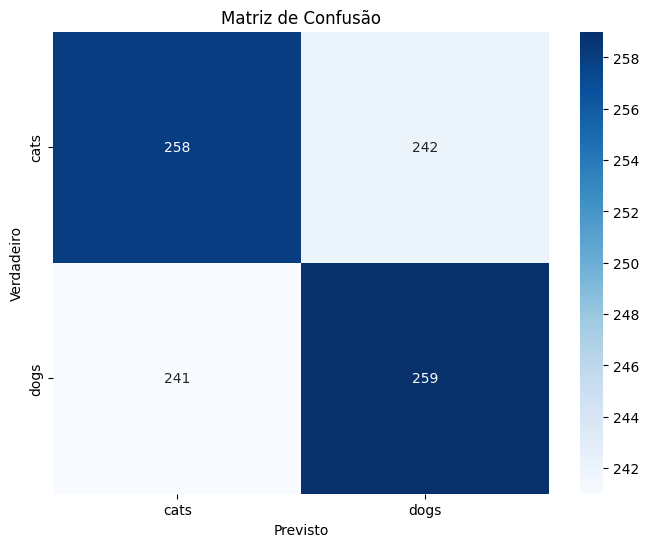


Relatório de Classificação:
              precision    recall  f1-score   support

        cats       0.52      0.52      0.52       500
        dogs       0.52      0.52      0.52       500

    accuracy                           0.52      1000
   macro avg       0.52      0.52      0.52      1000
weighted avg       0.52      0.52      0.52      1000



In [ ]:
# Carregar o melhor modelo salvo pelo ModelCheckpoint
best_model = keras.models.load_model("best_model.h5")

# Avaliar no conjunto de validação
loss, accuracy = best_model.evaluate(validation_generator)
print(f"Acurácia final no conjunto de validação: {accuracy*100:.2f}%")

# Plotar Matriz de Confusão
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Obter as previsões e os rótulos reais
Y_pred = best_model.predict(validation_generator)
y_pred = (Y_pred > 0.5).astype(int).flatten() # Converter probabilidades em 0 ou 1
y_true = validation_generator.classes

# Gerar a matriz de confusão
cm = confusion_matrix(y_true, y_pred)
class_names = list(validation_generator.class_indices.keys())

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Matriz de Confusão')
plt.ylabel('Verdadeiro')
plt.xlabel('Previsto')
plt.show()

# Imprimir o relatório de classificação
print("\nRelatório de Classificação:")
print(classification_report(y_true, y_pred, target_names=class_names))

Passo 7: Testando com uma Nova Imagem da Internet

* Esta é a prova final! Vamos dar uma imagem aleatória para o modelo e ver o que ele diz.

In [ ]:
# Importações necessárias (provavelmente já foram feitas, mas é bom garantir)
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

def predict_local_image(image_path, model):
    """
    Carrega uma imagem de um caminho local, pré-processa e faz a previsão.

    Args:
        image_path (str): O caminho para o arquivo de imagem (ex: 'meu_gato.jpg').
        model (keras.Model): O modelo treinado.
    """
    try:
        # Carregar a imagem do arquivo, redimensionando para o tamanho esperado pelo modelo
        img = image.load_img(image_path, target_size=IMG_SIZE)

        # Converter a imagem para um array NumPy
        img_array = image.img_to_array(img)

        # Expandir as dimensões para criar um "batch" de 1 imagem: (altura, largura, canais) -> (1, altura, largura, canais)
        img_array = np.expand_dims(img_array, axis=0)

        # Pré-processar a imagem da mesma forma que os dados de treino
        # (normalização específica da MobileNetV2)
        img_processed = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)

        # Fazer a previsão com o modelo
        prediction = model.predict(img_processed)

        # --- Apresentação do Resultado ---

        # Mostrar a imagem original
        plt.imshow(img)
        plt.axis('off')

        # Interpretar a saída do modelo (sigmóide) e mostrar o resultado
        score = prediction[0][0]
        # Lembre-se que o ImageDataGenerator ordena as classes alfabeticamente: 'cats' é 0, 'dogs' é 1.
        if score < 0.5:
            confidence = 100 * (1 - score)
            label = "GATO"
        else:
            confidence = 100 * score
            label = "CÃO"

        plt.title(f"Previsão: {label} ({confidence:.2f}%)")
        plt.show()

    except FileNotFoundError:
        print(f"ERRO: Arquivo não encontrado em '{image_path}'.")
        print("Você fez o upload do arquivo para o ambiente do Colab?")
    except Exception as e:
        print(f"Ocorreu um erro ao processar a imagem: {e}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


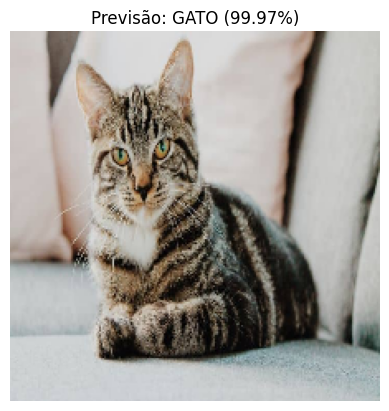

In [ ]:
image_to_predict = 'cat.jpg'
predict_local_image(image_to_predict, best_model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


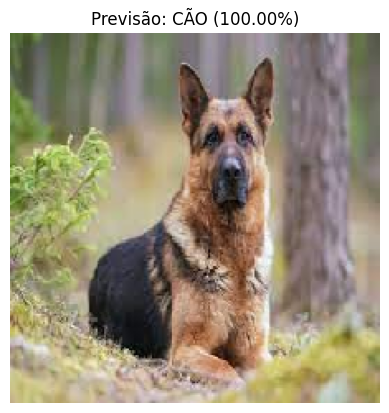

In [ ]:
predict_local_image('dog_1.jpg', best_model)